In [1]:
import time
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, accuracy_score
from tqdm.notebook import tqdm
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from plots import *

## KNN Class

In [2]:
class KNN:
    def __init__(self, k=3):
        self.k = k
        self.X_train = None
        self.y_train = None
    
    @staticmethod
    def distance(x, y):
        return np.linalg.norm(x - y)
    
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        
    def predict(self, X):
        y_pred = [self._predict(x) for x in X]
        return np.array(y_pred)
    
    def _predict(self, x):
        distances = [self.distance(x, x_train) for x_train in self.X_train]
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        
        # Calculate inverse distances
        inv_distances = [1 / d if d != 0 else float('inf') for d in distances]
        
        # Weighted voting
        vote_counts = Counter()
        for i, label in zip(k_indices, k_nearest_labels):
            vote_counts[label] += inv_distances[i]  # Weighted voting
            
        # Get the most common label
        most_common = vote_counts.most_common(1)
        return most_common[0][0]


## PCA Function

In [3]:
def pca_reduction(matrix, n_components=2):
    covariance_matrix = np.cov(matrix.transpose()) # Transpose the features into row vectors, to compute the covariance between the random variables
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix) # Compute the eigenvalues and vectors for the covariance matrix 
    indices = np.argsort(eigenvalues)[::-1][:n_components] # Sort in descending order
    eigenvalues, eigenvectors = eigenvalues[indices], eigenvectors[:, indices] # Numpy returns the eigenvectors as column vectors, therefore we sort along the columns
    result = matrix @ eigenvectors
    return dict(eigenvalues=eigenvalues, eigenvectors=eigenvectors, matrix=np.array(result))

## Mectris Function

In [4]:
def metrics(idx, labels, predictions):
    return np.array([
        accuracy_score(labels, predictions),
        f1_score(labels, predictions, pos_label=idx, zero_division=1),
        recall_score(labels, predictions, pos_label=idx, zero_division=1),
        precision_score(labels, predictions, pos_label=idx, zero_division=1)
    ])

## Fit and Predict Function

In [5]:
def fit_predict(k, x_train, y_train, x_test, y_test):
    clf = KNN(k=k)
    clf.fit(x_train, y_train)
    predictions = clf.predict(x_test)
    metrics_class_0 = metrics(0, labels=y_test, predictions=predictions)
    metrics_class_1 = metrics(1, labels=y_test, predictions=predictions)
    return dict(accuracy=metrics_class_1[0], predictions=predictions, clf=clf, metrics=dict(class0=metrics_class_0, class1=metrics_class_1))

## Load Dataset

In [6]:
dataset = pd.read_csv('./dataset/Social_Network_Ads.csv')
dataset.drop('User ID', axis=1, inplace=True)

## Encode numerical and categorical features

In [7]:
ordinal_encoder = OrdinalEncoder()
scaler_salary = MinMaxScaler()
scaler_age = MinMaxScaler()
dataset.Gender = ordinal_encoder.fit_transform(dataset.Gender.array.reshape(-1, 1))
dataset.EstimatedSalary = scaler_salary.fit_transform(dataset.EstimatedSalary.array.reshape(-1, 1))
dataset.Age = scaler_age.fit_transform(dataset.Age.array.reshape(-1, 1))

In [8]:
data = np.array(dataset)

# Split data into features and Labels

In [9]:
X, y = data[:, :-1], data[:, -1]

## Compare my pca against scikits pca

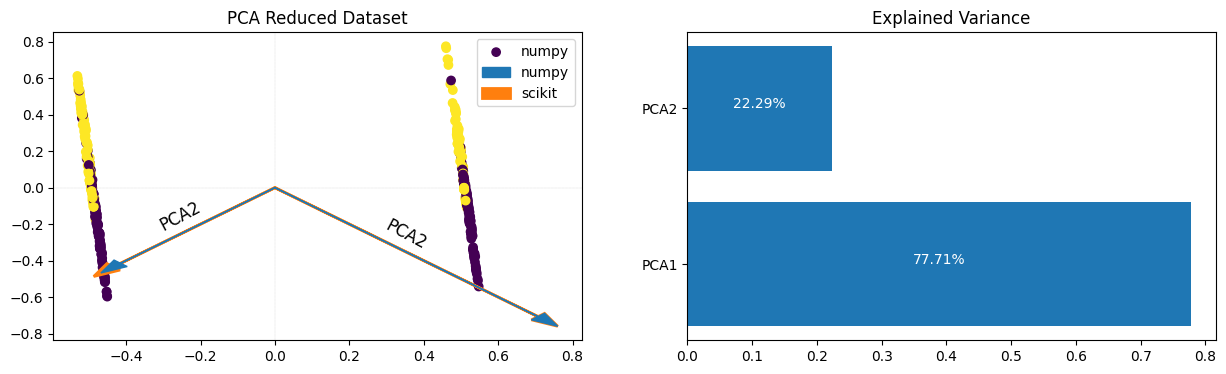

In [10]:
plot_pca(X, pca_reduction, y)

## Fit KNN to unreduced data 

In [11]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
config = dict(k=11, show_plot=False, x_train=np.array(x_train), x_test=np.array(x_test), y_train=np.array(y_train), y_test=np.array(y_test))

In [12]:
%%time
values2 = [plot_knn(**{**config, 'k':_}, predict_func=fit_predict) for _ in tqdm(range(1, 300))]

  0%|          | 0/299 [00:00<?, ?it/s]

CPU times: total: 16 s
Wall time: 25.3 s


<Figure size 900x350 with 0 Axes>

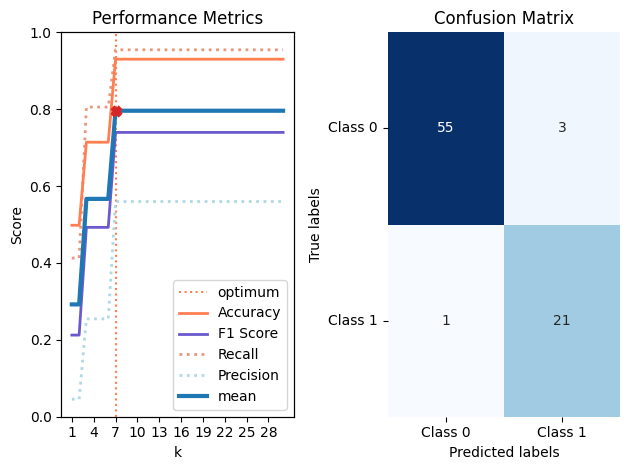

In [13]:
fig2 = plot_metric_confusion_matrix(y_test=y_test, logs=values2, figsize=(9, 3.5))

## Fit PCA to reduced data

In [17]:
x = pca_reduction(X, n_components=2)['matrix']
rx_train, rx_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
config = dict(k=11, show_plot=False, x_train=rx_train, x_test=rx_test, y_train=np.array(y_train), y_test=np.array(y_test))

In [15]:
%%time
values3 = [plot_knn(**{**config, 'k':_}, predict_func=fit_predict) for _ in tqdm(range(1, 300))]

  0%|          | 0/299 [00:00<?, ?it/s]

CPU times: total: 17 s
Wall time: 27.3 s


<Figure size 900x350 with 0 Axes>

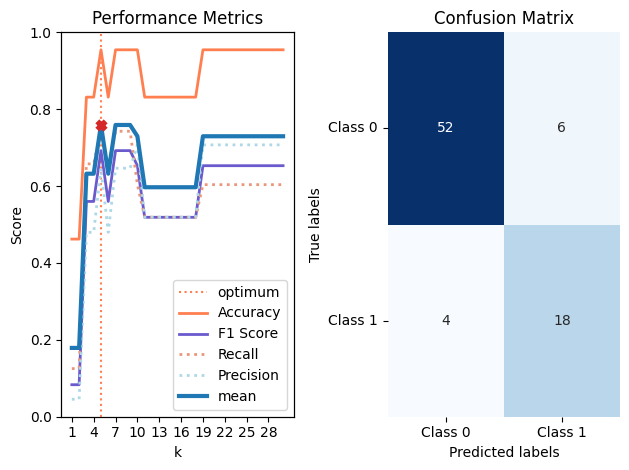

In [16]:
fig = plot_metric_confusion_matrix(y_test=y_test, logs=values3, figsize=(9, 3.5))